# Experiment 1: All metrics / Default parameters / TSB

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import importlib

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_tsb')
results_path = os.path.join(experiment_path, 'results')

%load_ext autoreload
%autoreload 2
import SylliGraph
importlib.reload(SylliGraph)
sgraph = SylliGraph.SylliGraph(experiment_path)

In [3]:
result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()

    anom_time_col = [x for x in curr_df.columns if 'oordinates' in x.lower()]
    if len(anom_time_col) > 0:
        curr_df = curr_df.rename({anom_time_col[0]: 'Anomaly coordinates time'}, axis=1)
    
    df = pd.concat([df, curr_df], ignore_index=True)
    
df['Metric'] = df['Metric'].map(sgraph.formal_names)
df.sample(3)

Number of result files: 7


100%|██████████| 7/7 [00:00<00:00, 107.15it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Existence,Step,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
5220,GHL/15_Lev_fault_Temp_corr_seed_49_vars_23.tes...,200000,1,144.0,NaN,AFFILIATION,0.663255,0.052494,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1249,YAHOO/YahooA3Benchmark-TS23_data.out,1679,15,1.0,128.0,Range-AUC (L: 128),0.778765,0.004282,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3519,NAB/NAB_data_CloudWatch_2.out,4030,2,200.0,128.0,VUS (L: 128),0.327318,0.366106,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

### Run time comparison on TSB

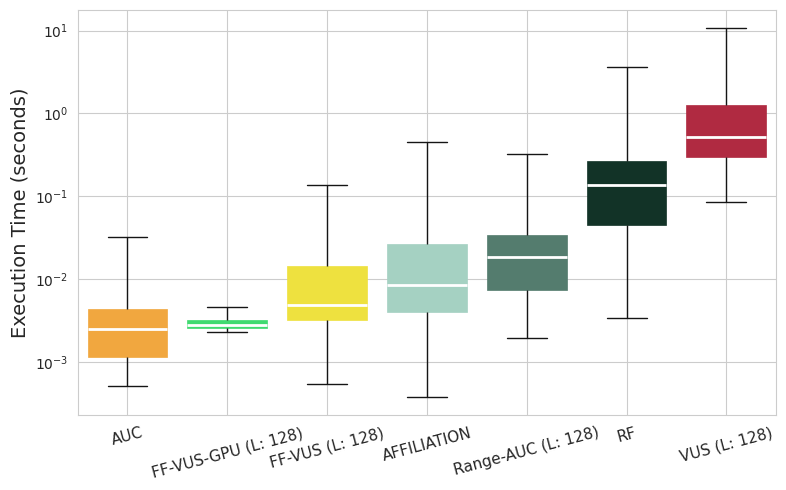

In [14]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

sgraph.boxplot_exec_time(df=df, order=order, filename='exec_time_comparison', title='', xlabel='', ylabel='Execution Time (seconds)')

### Error analysis on TSB: FFVUS VS VUS

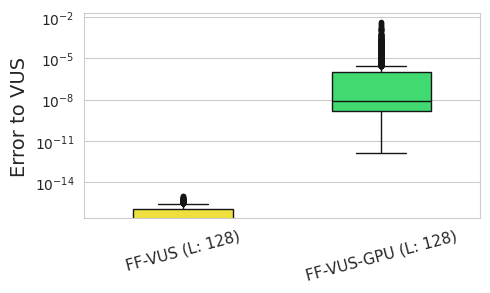

In [15]:
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()

sgraph.boxplot_error(dif_df, filename='ffvus_error_analysis', ylabel='Error to VUS', xlabel='')

In [6]:
dif_df.sort_values(by='FF-VUS-GPU (L: 128)', ascending=False).head(2)
# prob_ts = list(dif_df.sort_values(by='FF-VUS-GPU (L: 128)', ascending=False).head(2).index)
# df[np.logical_and(df['Time series'].isin(prob_ts), df['Metric'] == 'FF-VUS-GPU (L: 128)')]

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128)
Time series,,
MITDB/213.test.csv@2.out,1.110223e-16,0.004074
SVDB/891.test.csv@2.out,2.220446e-16,0.003538


In [17]:
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    dif_df[attr] = dif_df.apply(
        lambda row: df.loc[df['Time series'] == row.name, attr].values[0],
        axis=1
    )

In [18]:
dif_df

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128),Length,Number of anomalies,Anomalies average length
Time series,,,,,
Daphnet/S01R02E0.test.csv@1.out,0.000000e+00,1.677621e-08,28799,5,309.4
Daphnet/S01R02E0.test.csv@4.out,0.000000e+00,7.568250e-07,28799,5,309.4
Daphnet/S01R02E0.test.csv@6.out,0.000000e+00,5.137035e-08,28799,5,309.4
Daphnet/S02R01E0.test.csv@3.out,1.110223e-16,1.811098e-09,25599,9,393.0
Daphnet/S02R01E0.test.csv@4.out,0.000000e+00,1.431490e-08,25599,9,393.0
...,...,...,...,...,...
YAHOO/Yahoo_A2synthetic_96_data.out,1.110223e-16,2.339115e-08,1420,1,1.0
YAHOO/Yahoo_A2synthetic_97_data.out,2.220446e-16,5.871694e-08,1420,2,2.0
YAHOO/Yahoo_A2synthetic_98_data.out,0.000000e+00,7.457830e-09,1420,3,3.0


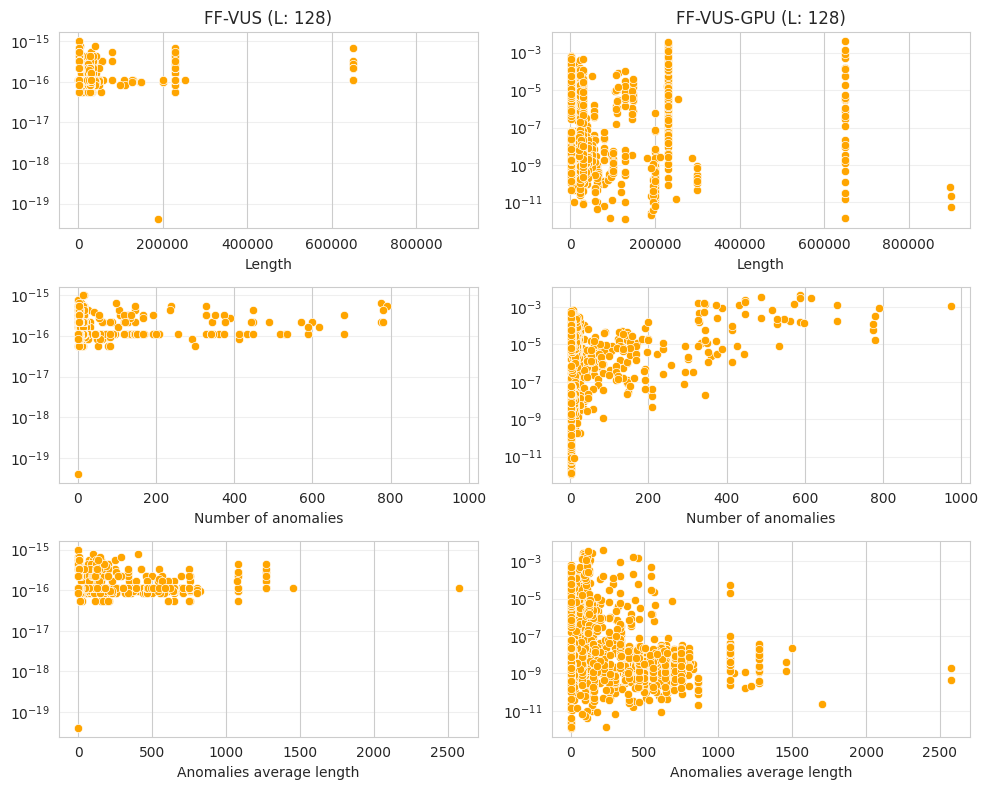

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
curr_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
for i, attr in enumerate(attributes):
    for j, metric in enumerate(curr_metrics):
        sns.scatterplot(dif_df, y=metric, x=attr, ax=ax[i, j], color='orange')
        ax[i, j].set_yscale('log')
        ax[i, j].grid(axis='y', alpha=0.3)
        ax[i, j].set_ylabel('')
        if i == 0:
            ax[i, j].set_title(metric)
        

plt.tight_layout()
plt.show()

## Time analysis (Not important on TSB, skip)

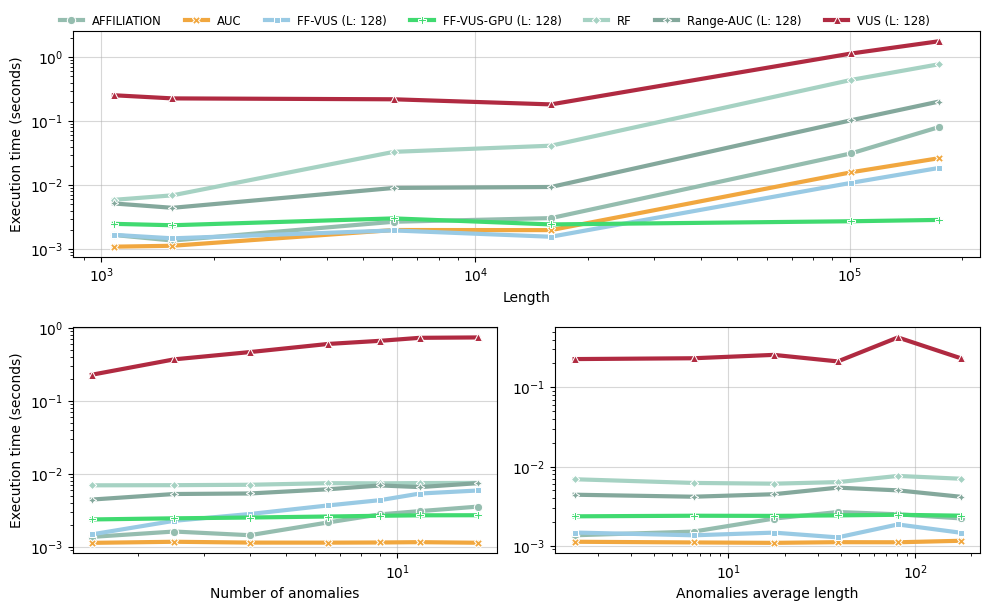

In [ ]:
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4)
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    for attr in attributes:
        if attr != attribute:
            mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )

    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center',
        y='Metric time',
        hue='Metric',
        data=grouped,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=3,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis

handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

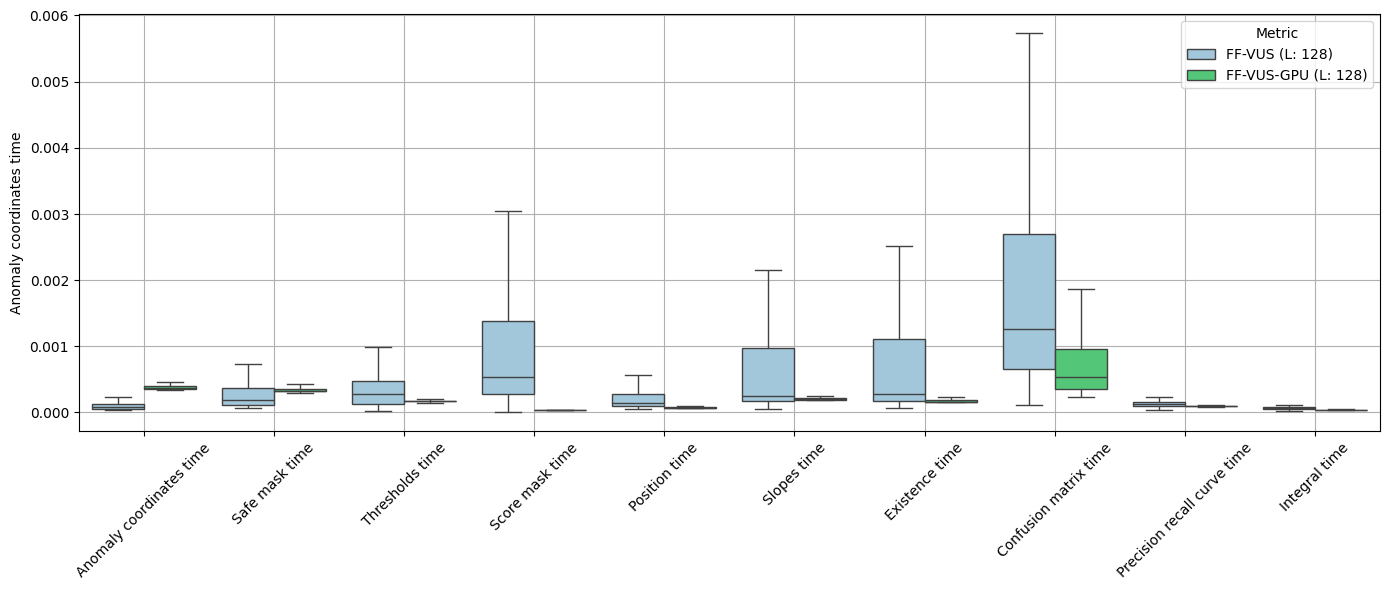

In [93]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    sns.boxplot(curr_df, x=i, y=col, log_scale=False, hue='Metric', legend=(i == 0), palette=color_palette, showfliers=False)
ax.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
ax.tick_params(axis='x', rotation=45)
ax.grid()

plt.tight_layout()
plt.show()

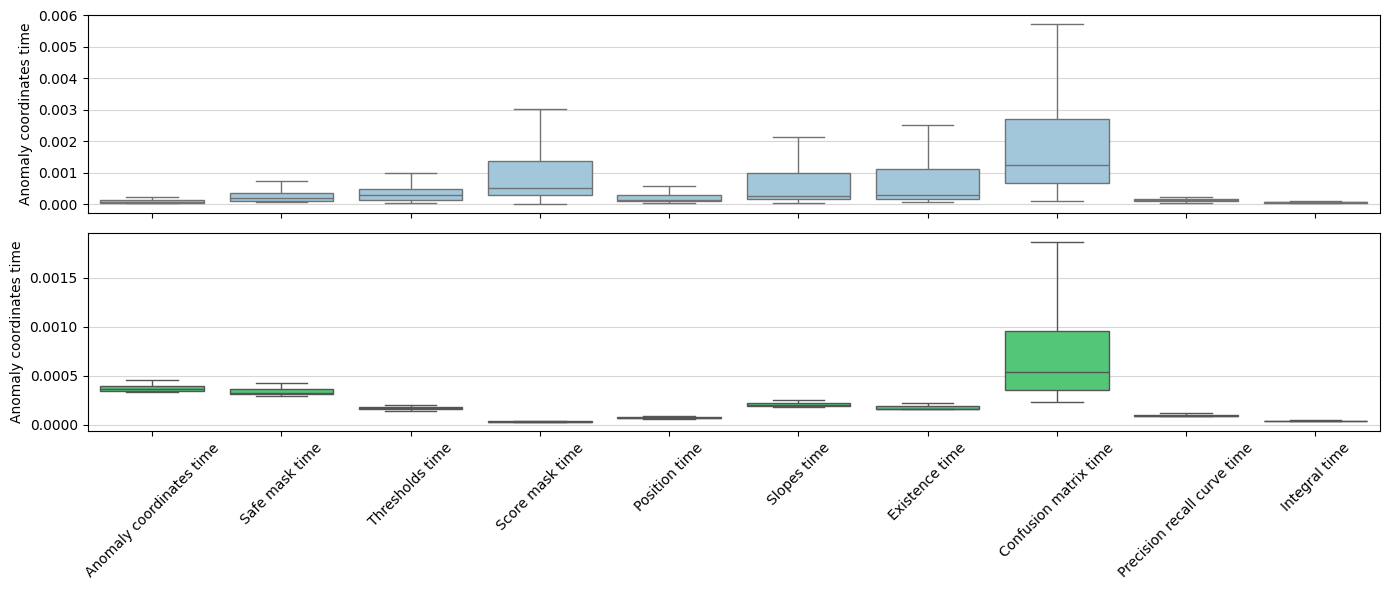

In [94]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharey=False)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(curr_df[curr_df['Metric'] == metrics[j]], ax=axis, x=i, y=col, log_scale=False, legend=(i == 0), color=color_palette[metrics[j]], showfliers=False)
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

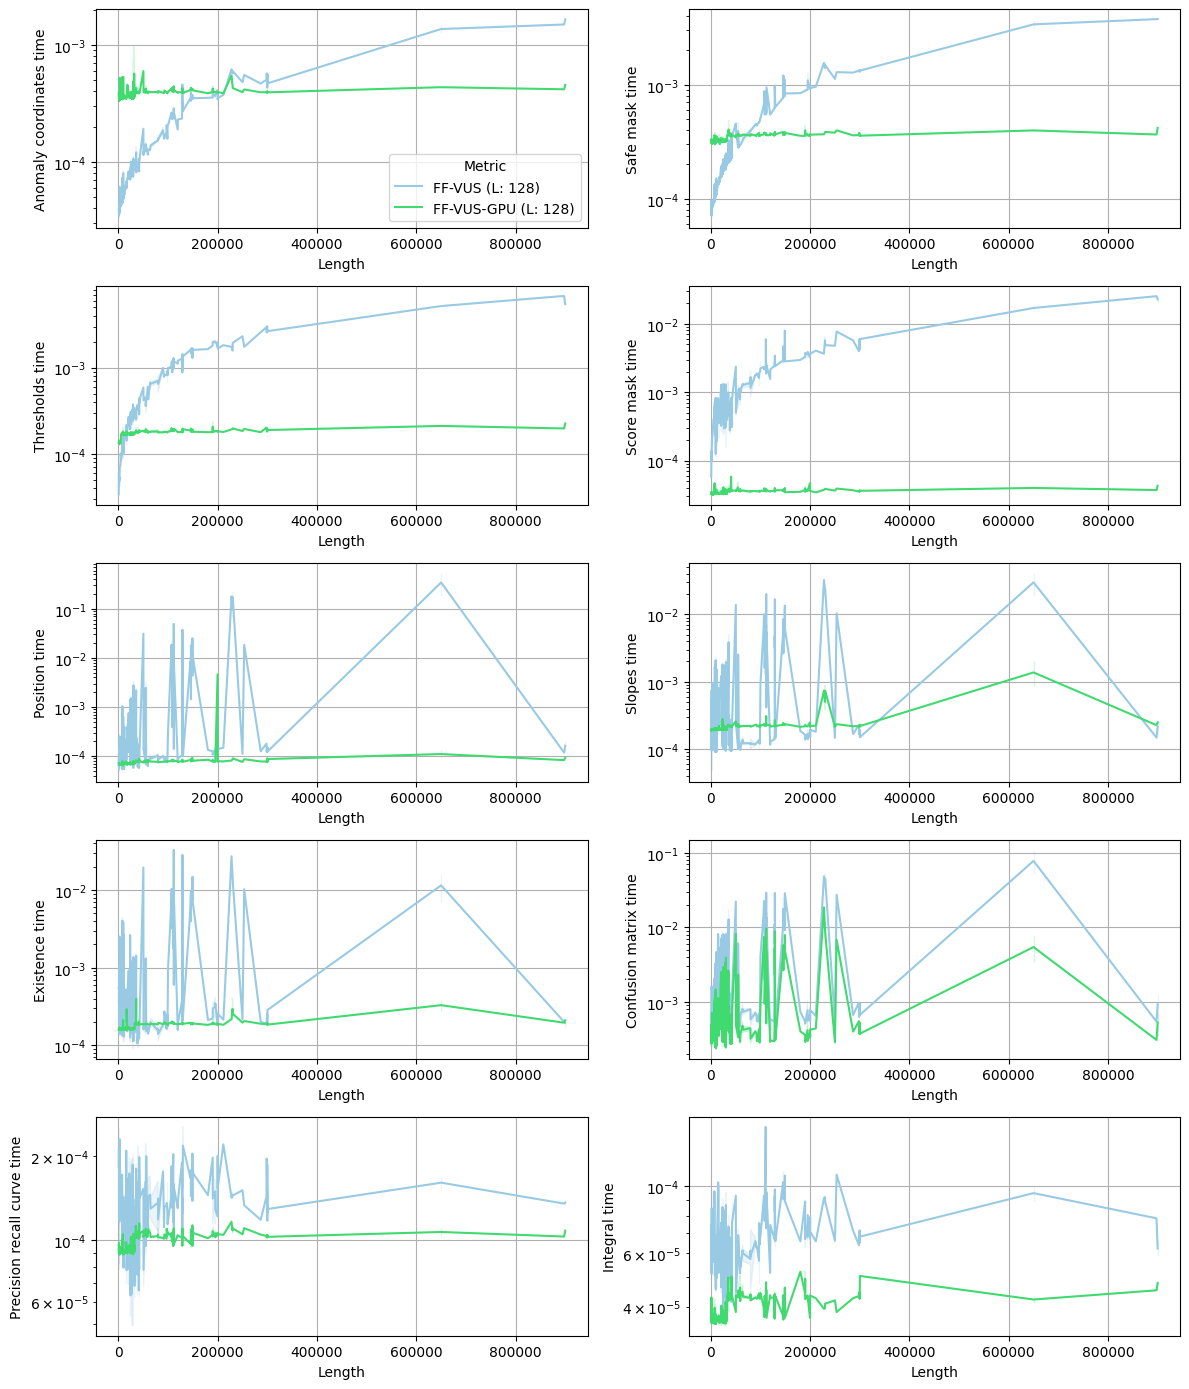

In [95]:
fig, ax = plt.subplots(5, 2, figsize=(12, 14))

for col, axis in zip(time_analysis_cols, ax.flatten()):
    sns.lineplot(
        curr_df, 
        x='Length', 
        y=col, 
        hue='Metric', 
        ax=axis, 
        legend=(col == 'Anomaly coordinates time'), 
        palette=color_palette
    )
    axis.set_yscale('log')
    axis.grid()
plt.tight_layout()
plt.show()